## Yeşil Alan Optimizasyonu Projesi: Veri Görselleştirme ve Analiz

Bu notebook, İstanbul ilçeleri için yeşil alan optimizasyonu projesinin sonuçlarını içeren `optimum_yesil_alan_sonuclari.csv` dosyasındaki verileri kullanarak çeşitli görselleştirmeler ve karşılaştırmalar yapmayı amaçlamaktadır.

Kullanılan temel metrikler şunlardır:
- Mevcut yeşil alan (`alan_metrekare`)
- Nüfus (`Nufus`)
- Ulaşım olanakları (Minibüs durakları, Raylı sistem istasyonları, Taksi durakları)
- Ortalama Hava Kalitesi İndeksi (`Ortalama_AQI`)
- Proje kapsamında hesaplanan Ulaşım Skoru ($T_i$) ve Hava Kalitesi Skoru ($S_i$)
- Genetik Algoritma (GA) ile eklenen ve toplam yeşil alan (`GA_Yeni_Yesil_Alan`, `GA_Toplam_Yesil_Alan`)
- Parçacık Sürü Optimizasyonu (PSO) ile eklenen ve toplam yeşil alan (`PSO_Yeni_Yesil_Alan`, `PSO_Toplam_Yesil_Alan`)

**Proje Kısıtlarından Bazıları (Referans Amaçlı):**
1. Her bir ilçe için maksimum yeşil alan büyüklüğü: $x_i \le A_{max,i}$
2. Her bir ilçenin nüfusuna göre belirlenen kişi başı minimum yeşil alan: $\frac{GA_i+x_i}{P_i} \ge \delta$
3. Pozitif yeşil alan: $x_i \ge 0$

Burada $x_i$ ilçeye eklenen yeni yeşil alanı, $GA_i$ mevcut yeşil alanı, $P_i$ nüfusu ve $\delta$ kişi başı hedeflenen minimum yeşil alan miktarını temsil eder. $A_{max,i}$ verimizde bulunmamaktadır.

### 1. Kütüphanelerin Yüklenmesi ve Veri Setinin Okunması

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Matplotlib ayarları ve Türkçe karakterler için
plt.rcParams['font.family'] = 'DejaVu Sans' # veya sisteminizde yüklü Türkçe karakter destekleyen bir font
plt.rcParams['axes.unicode_minus'] = False # Eksi işaretlerinin doğru gösterimi için

# Genel grafik ayarları
sns.set_style("whitegrid")

# Veri setini yükle
file_path = 'optimum_yesil_alan_sonuclari.csv'
try:
    df = pd.read_csv(file_path)
    print("CSV dosyası başarıyla yüklendi.")
except FileNotFoundError:
    print(f"Hata: '{file_path}' dosyası bulunamadı. Lütfen dosya yolunu kontrol edin.")
except Exception as e:
    print(f"Dosya okunurken bir hata oluştu: {e}")

CSV dosyası başarıyla yüklendi.


### 2. Veri Setine Genel Bakış

In [2]:
if 'df' in locals():
    print("Veri setinin ilk 5 satırı:")
    display(df.head())
    print("\nVeri seti hakkında bilgiler:")
    df.info()
    print("\nVeri setindeki sayısal sütunlar için temel istatistikler:")
    display(df.describe())
    print("\nEksik değerlerin kontrolü:")
    print(df.isnull().sum())

Veri setinin ilk 5 satırı:


,ILCE,alan_metrekare,Nufus,Minibus_Durak_Sayisi,Rayli_Istasyon_Sayisi,Taksi_Durak_Sayisi,Ortalama_AQI,Ti,Si,Yeni_Yapilacak_Yesil_Alan,Toplam_Yesil_Alan
0,ADALAR,51158.829550,16979.0,0,0,0,21.872800,0,10.936400,6070.502755,57229.332305
1,ARNAVUTKÖY,64545.192126,344868.0,204,5,2,29.735716,216,122.867858,32263.638325,96808.830450
2,ATAŞEHİR,652554.349856,414866.0,293,8,29,29.787501,338,183.893751,59579.842303,712134.192159
3,AVCILAR,758438.617676,440934.0,153,2,12,29.202595,169,99.101298,48228.622687,806667.240363
4,BAHÇELİEVLER,172658.041124,560086.0,240,9,14,36.609391,272,154.304696,86305.058660,258963.099784



Veri seti hakkında bilgiler:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ILCE                       39 non-null     object 
 1   alan_metrekare             39 non-null     float64
 2   Nufus                      39 non-null     float64
 3   Minibus_Durak_Sayisi       39 non-null     int64  
 4   Rayli_Istasyon_Sayisi      39 non-null     int64  
 5   Taksi_Durak_Sayisi         39 non-null     int64  
 6   Ortalama_AQI               39 non-null     float64
 7   Ti                         39 non-null     int64  
 8   Si                         39 non-null     float64
 9   Yeni_Yapilacak_Yesil_Alan  39 non-null     float64
 10  Toplam_Yesil_Alan          39 non-null     float64
dtypes: float64(6), int64(4), object(1)
memory usage: 3.5+ KB

Veri setindeki sayısal sütunlar için temel istatistikler:


,alan_metrekare,Nufus,Minibus_Durak_Sayisi,Rayli_Istasyon_Sayisi,Taksi_Durak_Sayisi,Ortalama_AQI,Ti,Si,Yeni_Yapilacak_Yesil_Alan,Toplam_Yesil_Alan
count,3.900000e+01,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,3.900000e+01
mean,1.404675e+06,402605.179487,203.205128,8.641026,15.717949,35.881373,236.205128,136.043251,76923.076923,1.481598e+06
std,1.356832e+06,205089.707299,98.571422,7.747622,13.911277,8.208693,104.827221,53.513727,47556.546689,1.378281e+06
min,2.938079e+04,16979.000000,0.000000,0.000000,0.000000,21.872800,0.000000,10.936400,6070.502755,4.406711e+04
25%,5.526484e+05,266567.000000,143.500000,2.500000,7.000000,29.735716,157.500000,98.573301,43034.745105,6.153023e+05
50%,8.603833e+05,414866.000000,204.000000,8.000000,12.000000,36.609391,240.000000,139.732188,65792.947524,9.395881e+05
75%,1.916942e+06,507529.000000,275.000000,10.500000,19.500000,39.464375,304.000000,170.924946,103860.249216,2.010397e+06
max,7.189931e+06,988369.000000,396.000000,27.000000,62.000000,65.461889,448.000000,242.117704,208748.669130,7.301356e+06



Eksik değerlerin kontrolü:
ILCE                         0
alan_metrekare               0
Nufus                        0
Minibus_Durak_Sayisi         0
Rayli_Istasyon_Sayisi        0
Taksi_Durak_Sayisi           0
Ortalama_AQI                 0
Ti                           0
Si                           0
Yeni_Yapilacak_Yesil_Alan    0
Toplam_Yesil_Alan            0
dtype: int64


### 3. Görselleştirmeler

Bu bölümde, veri setindeki farklı değişkenleri ve optimizasyon sonuçlarını görselleştireceğiz.

#### 3.1. Mevcut Yeşil Alanların İlçelere Göre Dağılımı

Her bir ilçedeki mevcut yeşil alan miktarını ($m^2$ cinsinden) gösterir. Bu, optimizasyon öncesi durumu anlamak için temel bir görselleştirmedir.

C:\Users\Yusuf\AppData\Local\Temp\ipykernel_23220\1489998676.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='alan_metrekare', y='ILCE', data=df_sorted_mevcut, palette='viridis')


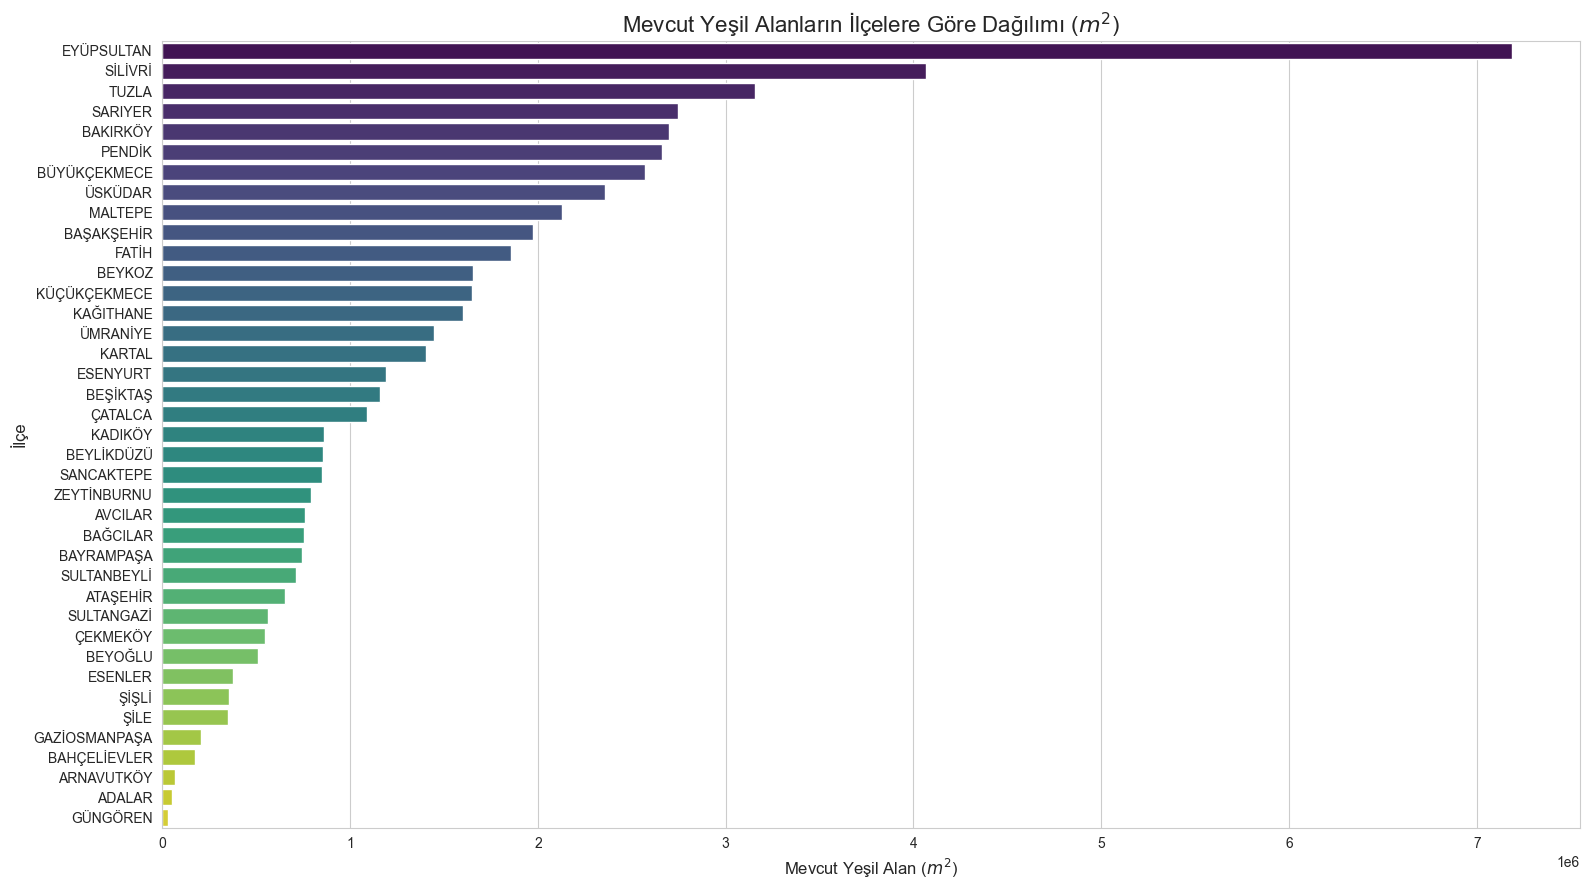

In [8]:
if 'df' in locals():
    df_sorted_mevcut = df.sort_values('alan_metrekare', ascending=False)
    plt.figure(figsize=(16, 9))
    sns.barplot(x='alan_metrekare', y='ILCE', data=df_sorted_mevcut, palette='viridis')
    plt.title('Mevcut Yeşil Alanların İlçelere Göre Dağılımı ($m^2$)', fontsize=16)
    plt.xlabel('Mevcut Yeşil Alan ($m^2$)', fontsize=12)
    plt.ylabel('İlçe', fontsize=12)
    plt.tight_layout()
    plt.show()

#### 3.2. GA Yöntemiyle Eklenen Yeşil Alan Miktarları

Genetik Algoritma (GA) yöntemiyle her bir ilçeye ne kadar yeni yeşil alan ($m^2$) eklendiğini karşılaştırmalı olarak gösterir.

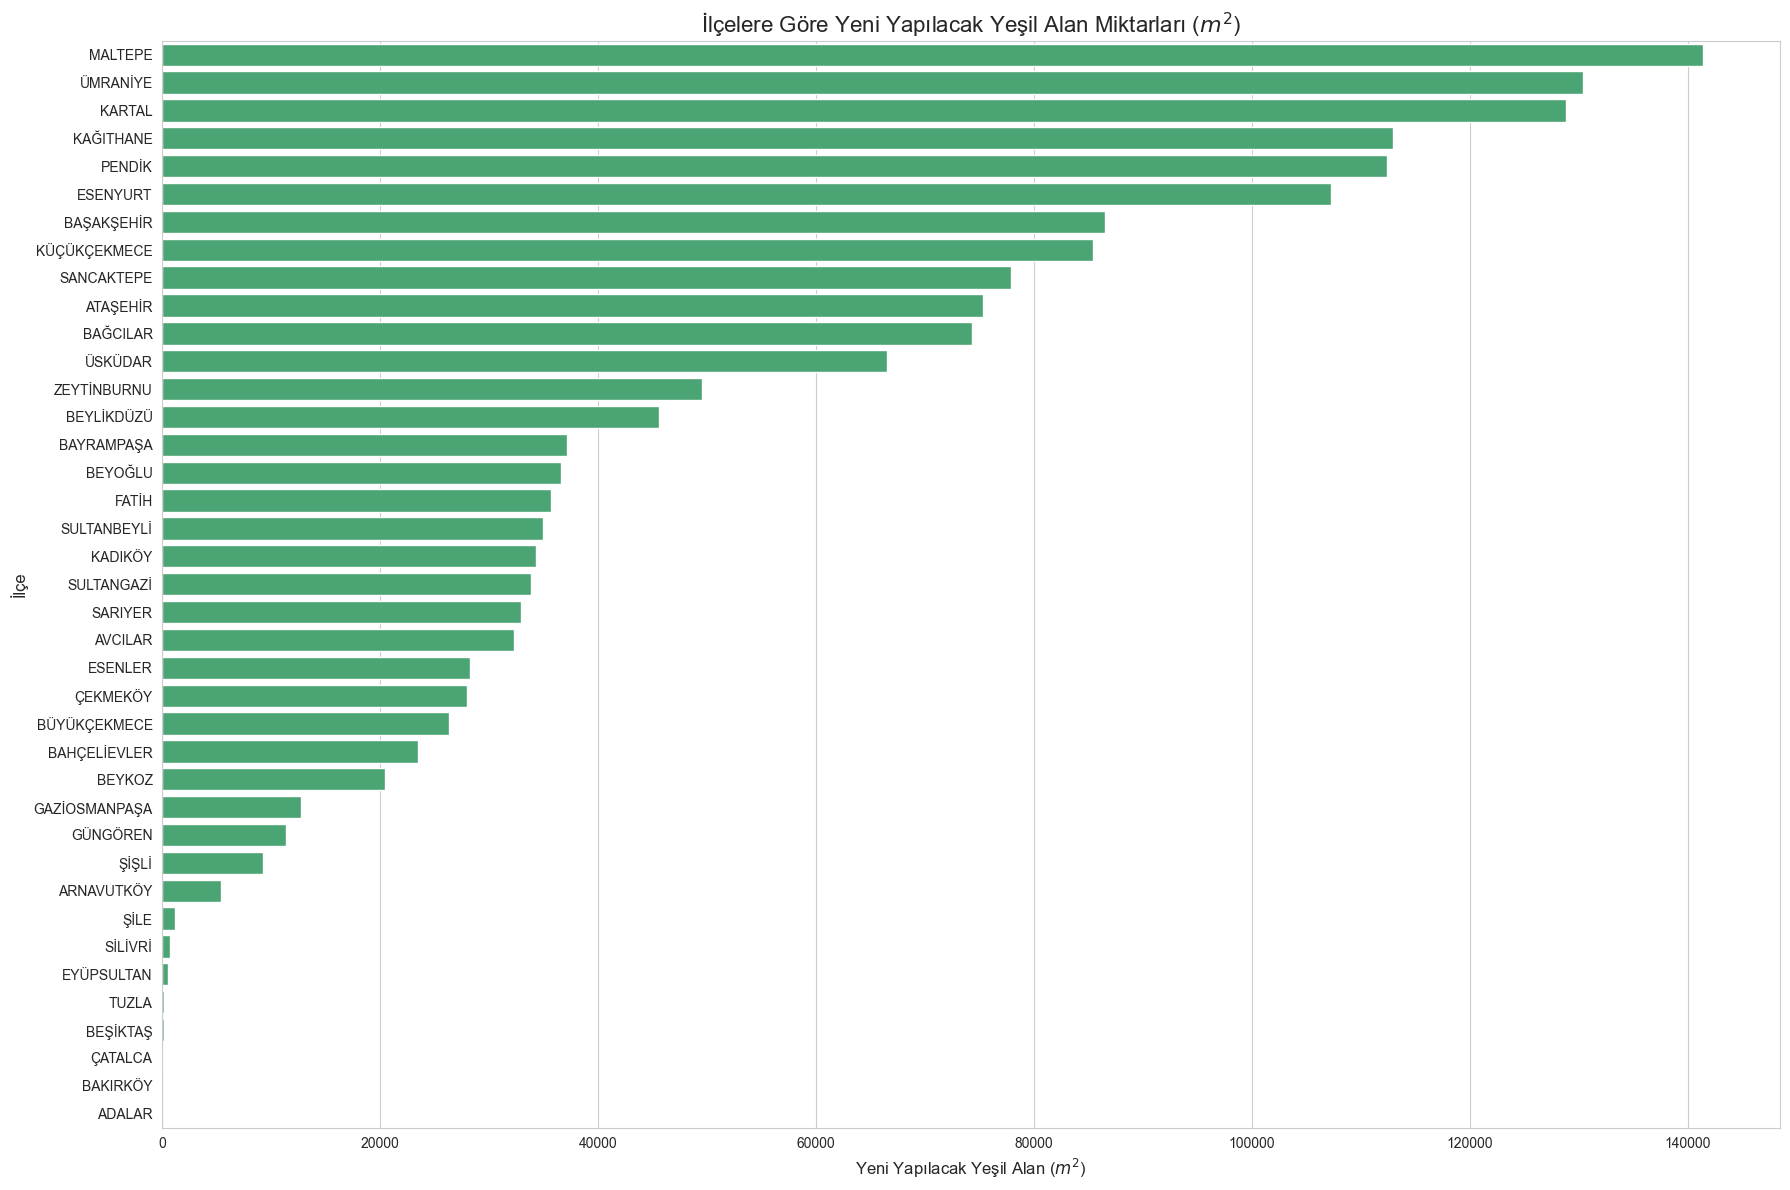

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# CSV dosyasını oku
df = pd.read_csv("optimum_yesil_alan_sonuclari.csv")

# İlçeleri eklenen yeşil alan miktarına göre sırala (daha okunaklı grafik için)
df_sorted = df.sort_values(by="Yeni_Yapilacak_Yesil_Alan", ascending=False)

# Grafik çizimi
plt.figure(figsize=(18, 12))
sns.barplot(x="Yeni_Yapilacak_Yesil_Alan", y="ILCE", data=df_sorted, color="mediumseagreen")
plt.title("İlçelere Göre Yeni Yapılacak Yeşil Alan Miktarları ($m^2$)", fontsize=16)
plt.xlabel("Yeni Yapılacak Yeşil Alan ($m^2$)", fontsize=12)
plt.ylabel("İlçe", fontsize=12)
plt.tight_layout()
plt.show()


#### 3.3. Mevcut ve Optimizasyon Sonrası Toplam Yeşil Alanların Karşılaştırılması

Her ilçe için mevcut yeşil alan miktarını, GA optimizasyonu sonrası toplam yeşil alan miktarını ve PSO optimizasyonu sonrası toplam yeşil alan miktarını ($m^2$) yan yana gösterir.

In [5]:
if 'df' in locals():
    df_toplam_melted = df.melt(id_vars='ILCE',
                               value_vars=['alan_metrekare', 'GA_Toplam_Yesil_Alan', 'PSO_Toplam_Yesil_Alan'],
                               var_name='Yeşil Alan Türü',
                               value_name='Alan ($m^2$)')
    df_toplam_melted['Yeşil Alan Türü'] = df_toplam_melted['Yeşil Alan Türü'].map({
        'alan_metrekare': 'Mevcut Yeşil Alan',
        'GA_Toplam_Yesil_Alan': 'Toplam Yeşil Alan (GA)',
        'PSO_Toplam_Yesil_Alan': 'Toplam Yeşil Alan (PSO)'
    })

    # İlçeleri mevcut yeşil alana göre sırala
    ilce_order_toplam = df.sort_values('alan_metrekare', ascending=False)['ILCE']

    plt.figure(figsize=(20, 15))
    sns.barplot(x='Alan ($m^2$)', y='ILCE', hue='Yeşil Alan Türü', data=df_toplam_melted,
                palette={'Mevcut Yeşil Alan': 'lightgreen', 'Toplam Yeşil Alan (GA)': 'salmon', 'Toplam Yeşil Alan (PSO)': 'lightblue'},
                order=ilce_order_toplam)
    plt.title('Mevcut ve Optimizasyon Sonrası Toplam Yeşil Alanların Karşılaştırılması ($m^2$)', fontsize=16)
    plt.xlabel('Yeşil Alan ($m^2$)', fontsize=12)
    plt.ylabel('İlçe', fontsize=12)
    plt.legend(title='Yeşil Alan Durumu')
    plt.tight_layout()
    plt.show()

KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['GA_Toplam_Yesil_Alan', 'PSO_Toplam_Yesil_Alan']"

#### 3.4. Kişi Başına Düşen Toplam Yeşil Alan (GA vs PSO)

GA ve PSO optimizasyonları sonucunda her bir ilçede kişi başına düşen toplam yeşil alan miktarını ($m^2$/kişi) karşılaştırır. Grafikte örnek olarak 10 $m^2$/kişi ve 15 $m^2$/kişi gibi hedefler de gösterilmiştir. Bu, $\frac{GA_i+x_i}{P_i} \ge \delta$ kısıtının sonuçlarını değerlendirmek için önemlidir.

In [ ]:
if 'df' in locals():
    df['Kişi Başı GA ($m^2$)'] = df['GA_Toplam_Yesil_Alan'] / df['Nufus']
    df['Kişi Başı PSO ($m^2$)'] = df['PSO_Toplam_Yesil_Alan'] / df['Nufus']

    df_kisi_basi_melted = df.melt(id_vars='ILCE', value_vars=['Kişi Başı GA ($m^2$)', 'Kişi Başı PSO ($m^2$)'],
                                   var_name='Hesaplama Yöntemi', value_name='Kişi Başı Yeşil Alan ($m^2$/kişi)')
    df_kisi_basi_melted['Hesaplama Yöntemi'] = df_kisi_basi_melted['Hesaplama Yöntemi'].map({
        'Kişi Başı GA ($m^2$)': 'GA ile Optimize Edilmiş',
        'Kişi Başı PSO ($m^2$)': 'PSO ile Optimize Edilmiş'
    })

    # İlçeleri ortalama kişi başı yeşil alana göre sırala
    ilce_order_kisi_basi = df.groupby('ILCE')[['Kişi Başı GA ($m^2$)', 'Kişi Başı PSO ($m^2$)']].mean().mean(axis=1).sort_values(ascending=False).index

    plt.figure(figsize=(18, 12))
    sns.barplot(x='Kişi Başı Yeşil Alan ($m^2$/kişi)', y='ILCE', hue='Hesaplama Yöntemi', data=df_kisi_basi_melted,
                palette={'GA ile Optimize Edilmiş': 'mediumseagreen', 'PSO ile Optimize Edilmiş': 'cornflowerblue'},
                order=ilce_order_kisi_basi)
    plt.title('Optimizasyon Sonrası Kişi Başına Düşen Toplam Yeşil Alan ($m^2$/kişi)', fontsize=16)
    plt.xlabel('Kişi Başına Düşen Yeşil Alan ($m^2$/kişi)', fontsize=12)
    plt.ylabel('İlçe', fontsize=12)
    plt.axvline(x=10, color='red', linestyle='--', label='Hedef $\delta_1$: 10 $m^2$/kişi') # Örnek bir hedef çizgi
    plt.axvline(x=15, color='darkred', linestyle='--', label='Hedef $\delta_2$: 15 $m^2$/kişi') # Örnek bir hedef çizgi
    plt.legend(title='Optimizasyon Yöntemi ve Hedefler')
    plt.tight_layout()
    plt.show()

#### 3.5. Eklenen Yeşil Alan ve Ortalama Hava Kalitesi İndeksi (AQI) İlişkisi

Her bir ilçe için optimizasyonla eklenen yeşil alan miktarı ($m^2$) ile o ilçenin ortalama Hava Kalitesi İndeksi (AQI) arasındaki ilişkiyi gösterir. AQI'da düşük değerler daha iyi hava kalitesini ifade eder.

In [ ]:
if 'df' in locals():
    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x='Ortalama_AQI', y='GA_Yeni_Yesil_Alan', data=df, color='coral', s=100, alpha=0.7, legend=False)
    # Noktaların üzerine ilçe isimlerini yazmak için (isteğe bağlı, kalabalık olabilir):
    # for i in range(df.shape[0]):
    #     plt.text(df.Ortalama_AQI[i], df.GA_Yeni_Yesil_Alan[i], df.ILCE[i], fontsize=7)
    plt.title('GA: Eklenen Yeşil Alan vs. Ortalama AQI', fontsize=14)
    plt.xlabel('Ortalama Hava Kalitesi İndeksi (AQI)\n(Düşük değer daha iyi hava kalitesi)', fontsize=10)
    plt.ylabel('GA ile Eklenen Yeşil Alan ($m^2$)', fontsize=10)
    plt.grid(True)

    plt.subplot(1, 2, 2)
    sns.scatterplot(x='Ortalama_AQI', y='PSO_Yeni_Yesil_Alan', data=df, color='skyblue', s=100, alpha=0.7, legend=False)
    # for i in range(df.shape[0]):
    #     plt.text(df.Ortalama_AQI[i], df.PSO_Yeni_Yesil_Alan[i], df.ILCE[i], fontsize=7)
    plt.title('PSO: Eklenen Yeşil Alan vs. Ortalama AQI', fontsize=14)
    plt.xlabel('Ortalama Hava Kalitesi İndeksi (AQI)\n(Düşük değer daha iyi hava kalitesi)', fontsize=10)
    plt.ylabel('PSO ile Eklenen Yeşil Alan ($m^2$)', fontsize=10)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

#### 3.6. Eklenen Yeşil Alan ve Ulaşım Skoru ($T_i$) İlişkisi

Her bir ilçe için optimizasyonla eklenen yeşil alan miktarı ($m^2$) ile o ilçenin ulaşım skoru ($T_i$) arasındaki ilişkiyi gösterir. Ulaşım skorunda yüksek değerler daha iyi ulaşım imkanlarını ifade eder.

In [ ]:
if 'df' in locals():
    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x='Ti', y='GA_Yeni_Yesil_Alan', data=df, color='coral', s=100, alpha=0.7, legend=False)
    plt.title('GA: Eklenen Yeşil Alan vs. Ulaşım Skoru ($T_i$)', fontsize=14)
    plt.xlabel('Ulaşım Skoru ($T_i$)\n(Yüksek değer daha iyi ulaşım)', fontsize=10)
    plt.ylabel('GA ile Eklenen Yeşil Alan ($m^2$)', fontsize=10)
    plt.grid(True)

    plt.subplot(1, 2, 2)
    sns.scatterplot(x='Ti', y='PSO_Yeni_Yesil_Alan', data=df, color='skyblue', s=100, alpha=0.7, legend=False)
    plt.title('PSO: Eklenen Yeşil Alan vs. Ulaşım Skoru ($T_i$)', fontsize=14)
    plt.xlabel('Ulaşım Skoru ($T_i$)\n(Yüksek değer daha iyi ulaşım)', fontsize=10)
    plt.ylabel('PSO ile Eklenen Yeşil Alan ($m^2$)', fontsize=10)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

#### 3.7. GA vs. PSO ile Eklenen Yeşil Alan Miktarları (İlçe Bazlı Fark Karşılaştırması)

Her bir ilçe için PSO ile eklenen yeşil alan miktarı ile GA ile eklenen yeşil alan miktarı arasındaki farkı ($m^2$) gösterir. Pozitif değerler PSO'nun o ilçede GA'dan daha fazla alan önerdiğini, negatif değerler ise GA'nın daha fazla alan önerdiğini belirtir.

In [ ]:
if 'df' in locals():
    df_comparison = df[['ILCE', 'GA_Yeni_Yesil_Alan', 'PSO_Yeni_Yesil_Alan']].copy()
    df_comparison['Fark (PSO - GA) ($m^2$)'] = df_comparison['PSO_Yeni_Yesil_Alan'] - df_comparison['GA_Yeni_Yesil_Alan']
    df_comparison_sorted = df_comparison.sort_values('Fark (PSO - GA) ($m^2$)', ascending=False)

    plt.figure(figsize=(16, 10))
    sns.barplot(x='Fark (PSO - GA) ($m^2$)', y='ILCE', data=df_comparison_sorted, palette='coolwarm')
    plt.title('PSO ve GA ile Eklenen Yeşil Alan Miktarları Arasındaki Fark ($m^2$)\n(Pozitif: PSO > GA, Negatif: GA > PSO)', fontsize=16)
    plt.xlabel('Fark: PSO Eklenen Alan - GA Eklenen Alan ($m^2$)', fontsize=12)
    plt.ylabel('İlçe', fontsize=12)
    plt.axvline(0, color='black', lw=0.8)
    plt.tight_layout()
    plt.show()

#### 3.8. Temel Metriklerin Dağılımları (Ortalama AQI, Ulaşım Skoru ($T_i$), Hava Kalitesi Skoru ($S_i$))

İlçeler genelinde Ortalama AQI, Ulaşım Skoru ($T_i$) ve Hava Kalitesi Skoru ($S_i$) değerlerinin dağılımlarını gösterir. Bu, bu metriklerin genel yapısını anlamak için faydalıdır.

In [ ]:
if 'df' in locals():
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    sns.histplot(df['Ortalama_AQI'], kde=True, ax=axes[0], color='skyblue', bins=10)
    axes[0].set_title('Ortalama AQI Dağılımı', fontsize=14)
    axes[0].set_xlabel('Ortalama AQI', fontsize=10)
    axes[0].set_ylabel('Frekans', fontsize=10)

    sns.histplot(df['Ti'], kde=True, ax=axes[1], color='lightcoral', bins=10)
    axes[1].set_title('Ulaşım Skoru ($T_i$) Dağılımı', fontsize=14)
    axes[1].set_xlabel('Ulaşım Skoru ($T_i$)', fontsize=10)
    axes[1].set_ylabel('Frekans', fontsize=10)

    sns.histplot(df['Si'], kde=True, ax=axes[2], color='lightgreen', bins=10)
    axes[2].set_title('Hava Kalitesi Skoru ($S_i$) Dağılımı', fontsize=14)
    axes[2].set_xlabel('Hava Kalitesi Skoru ($S_i$)', fontsize=10)
    axes[2].set_ylabel('Frekans', fontsize=10)

    plt.tight_layout()
    plt.show()

### 4. Analizli Veri Setinin Kaydedilmesi

Hesaplanan kişi başı yeşil alan miktarları gibi ek bilgilerle güncellenmiş veri setini yeni bir CSV dosyasına kaydedelim.

In [ ]:
if 'df' in locals():
    # Kişi başı alan sütunlarının varlığını kontrol et, yoksa oluştur (önceki hücrelerde oluşturulmuş olmalı)
    if 'Kişi Başı GA ($m^2$)' not in df.columns:
        df['Kişi Başı GA ($m^2$)'] = df['GA_Toplam_Yesil_Alan'] / df['Nufus']
    if 'Kişi Başı PSO ($m^2$)' not in df.columns:
        df['Kişi Başı PSO ($m^2$)'] = df['PSO_Toplam_Yesil_Alan'] / df['Nufus']
        
    output_csv_path = 'optimum_yesil_alan_sonuclari_analizli.csv'
    try:
        df.to_csv(output_csv_path, index=False, encoding='utf-8-sig')
        print(f"\nAnalizli veri seti '{output_csv_path}' dosyasına başarıyla kaydedildi.")
    except Exception as e:
        print(f"Analizli veri seti kaydedilirken bir hata oluştu: {e}")

### 5. Sonuç

Bu notebook, sağlanan CSV dosyasındaki verileri kullanarak çeşitli karşılaştırmalı grafikler üretmiştir. Bu görselleştirmeler, Genetik Algoritma ve Parçacık Sürü Optimizasyonu yöntemlerinin İstanbul'daki yeşil alan dağılımını nasıl etkilediğini, mevcut durumla kıyaslamalarını, kişi başına düşen yeşil alan miktarlarını ve çeşitli çevresel/ulaşım faktörleriyle ilişkilerini ortaya koymaktadır. 

Elde edilen grafikler ve analizli veri seti, projenizin bulgularını daha etkili bir şekilde sunmanıza yardımcı olacaktır.